# t-SNE

In [ ]:
import import_ipynb
import utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [128]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
data_climat = utils.generate_df_from_files("./", "climate_cleaned")[0]


In [129]:
# Changer le nom de la colonne 2021(JO-2020) par 2020
data_pop[18] = data_pop[18].rename(columns={"2021(JO-2020)": "2020"})
data_fertility[18] = data_fertility[18].rename(columns={"2021(JO-2020)": "2020"})
data_child[18] = data_child[18].rename(columns={"2021(JO-2020)": "2020"})
data_capita[18] = data_capita[18].rename(columns={"2021(JO-2020)": "2020"})


In [130]:
countries = data_pop[0]["country"].values

In [135]:
# nombre de pays
len(countries)

197

In [131]:
years = [1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020]

In [136]:
# nombre d'années
len(years)

19

In [126]:
type(data_pop[0])

pandas.core.frame.DataFrame

In [132]:
# Initialiser une liste pour stocker toutes les années de données combinées
final_data = []

# Parcourir chaque année pour combiner les données
for i, year in enumerate(years):
    # Vérifier si l'année existe dans les colonnes des DataFrames
    year_str = str(year)  # Utiliser le format chaîne pour être sûr
    
    if year_str not in data_pop[i].columns:
        print(f"⚠️ L'année {year} n'existe pas dans le DataFrame data_pop[{i}]. Colonnes disponibles : {data_pop[i].columns}")
        continue

    # Récupérer les colonnes pertinentes pour chaque dataset
    pop_df = data_pop[i][["country", year_str]].rename(columns={year_str: "pop"})
    fertility_df = data_fertility[i][["country", year_str]].rename(columns={year_str: "fertility"})
    child_df = data_child[i][["country", year_str]].rename(columns={year_str: "child"})
    capita_df = data_capita[i][["country", year_str]].rename(columns={year_str: "capita"})

    # Joindre les DataFrames sur "country"
    merged_df = pd.DataFrame({"country": countries})
    merged_df = merged_df.merge(pop_df, on="country", how="left")
    merged_df = merged_df.merge(fertility_df, on="country", how="left")
    merged_df = merged_df.merge(child_df, on="country", how="left")
    merged_df = merged_df.merge(capita_df, on="country", how="left")

    # Ajouter l'année dans le DataFrame
    merged_df["year"] = year

    # Réordonner les colonnes pour mettre "year" avant "country"
    cols = ["year"] + [col for col in merged_df.columns if col != "year"]
    merged_df = merged_df[cols]

    # Ajouter les données climatiques (fixes pour chaque pays)
    merged_df = merged_df.merge(data_climat, on="country", how="left")

    # Ajouter au DataFrame final
    final_data.append(merged_df)

# Concaténer toutes les années en un seul DataFrame
final_df = pd.concat(final_data, ignore_index=True)

# Remplir les valeurs manquantes par 0 pour éviter les NaN dans t-SNE
final_df = final_df.fillna(0)

# Afficher un aperçu
print(final_df.head())

# Créer un array numpy pour t-SNE avec les colonnes pertinentes
X = final_df[['pop', 'fertility', 'child', 'capita', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity']].values
y = final_df['country'].values  # Noms des pays pour annotations

   year      country       pop  fertility     child    capita  \
0  1948  Afghanistan  0.014099   0.925180  0.922041  0.019265   
1  1948      Albania  0.002264   0.664748  0.605481  0.029281   
2  1948      Algeria  0.016347   0.928058  0.591306  0.045904   
3  1948      Andorra  0.000009   0.159712  0.463843  0.160344   
4  1948       Angola  0.008219   0.778417  0.742499  0.033330   

   Avg_Temperature  Avg_Precipitation  Avg_Seasonality  Avg_Aridity  
0         0.000000           0.000000         0.000000         0.00  
1         0.550000           0.600000         0.475000         0.45  
2         0.500000           0.360000         0.240000         0.64  
3         0.000000           0.000000         0.000000         0.00  
4         0.516667           0.483333         0.333333         0.50  


In [11]:
# Code Julien , ne marche pas très bien pour t-SNE
"""""
def organize_in_dict(data_list):
    data_dict = {}
    for e in data_list:
        year = int(e.columns[1][:4])
        if year == 2021:
            year = 2020
        data_dict[year] = e.set_index('country')
    return data_dict

data_pop = organize_in_dict(data_pop)
data_fertility = organize_in_dict(data_fertility)
data_child = organize_in_dict(data_child)
data_capita = organize_in_dict(data_capita)
data_climat.set_index('country', inplace=True)
"""

In [15]:
# Code Julien , ne marche pas très bien pour t-SNE
"""""
X_list = []
country_names = {}

for annee in years:
    print(annee)
    concatenated_data = pd.concat(
        [ data_pop[annee],
          data_fertility[annee],
          data_child[annee],
          data_capita[annee],
          data_climat ]
        , axis=1, join='inner')

    X_list.append(concatenated_data)
    country_names[annee] = np.array(concatenated_data.index)

X = np.vstack(X_list)
print(X.shape)
"""

1992
1996
2000
2004
2008
2012
2016
2020
(1144, 8)


## La perplexité est un hyperparamètre du t-SNE qui contrôle le nombre d'échantillons voisins considérés pour chaque point.

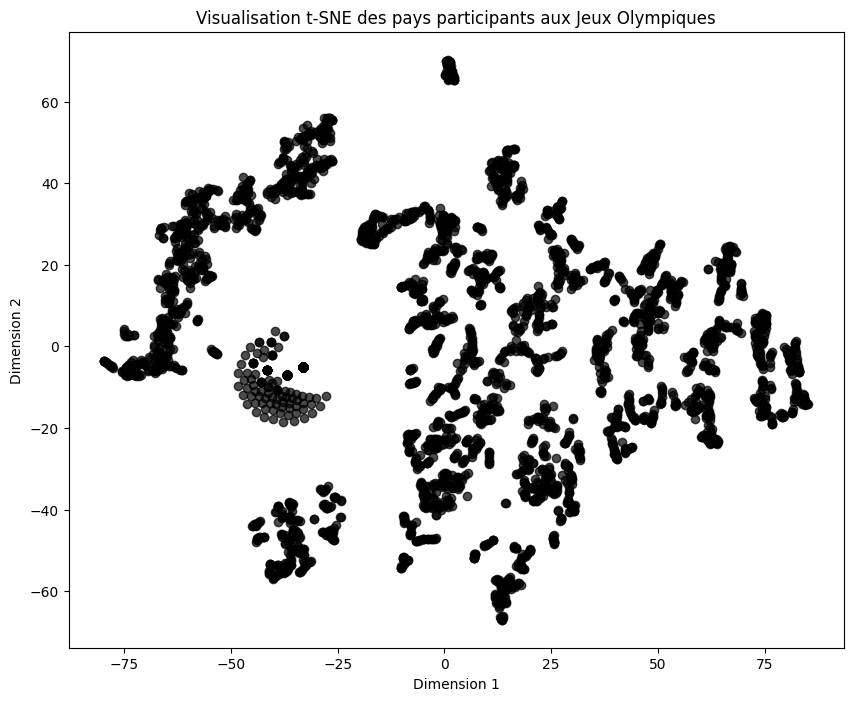

In [148]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Appliquer t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X)

# Visualisation
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, color='black')
plt.title("Visualisation t-SNE des pays participants aux Jeux Olympiques")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [163]:
import plotly.express as px
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne_2d = tsne.fit_transform(X)

# Ajouter les composantes t-SNE au DataFrame
final_df["TSNE1"] = X_tsne_2d[:, 0]
final_df["TSNE2"] = X_tsne_2d[:, 1]

# Visualisation interactive en 2D avec Plotly
fig = px.scatter(
    final_df,
    x="TSNE1",
    y="TSNE2",
    hover_name="country",  # Affiche le nom du pays en survol
    title="Visualisation t-SNE 2D des pays participants aux Jeux Olympiques",
    labels={"TSNE1": "Composante t-SNE 1", "TSNE2": "Composante t-SNE 2"},
    color_discrete_sequence=["black"],  # Couleur noire pour tous les points
    opacity=0.7  # Transparence
)

# Affichage interactif
fig.show()

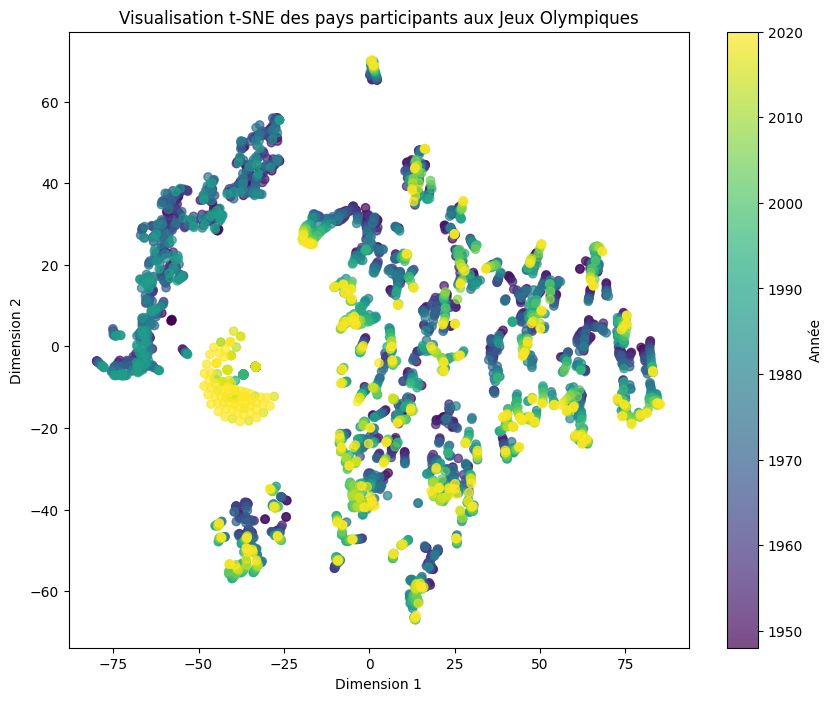

In [149]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Appliquer t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X)

# Visualisation
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=final_df["year"], cmap='viridis', alpha=0.7)
plt.title("Visualisation t-SNE des pays participants aux Jeux Olympiques")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Année")
plt.show()

In [164]:
import plotly.express as px
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne_2d = tsne.fit_transform(X)

# Ajouter les composantes t-SNE au DataFrame
final_df["TSNE1"] = X_tsne_2d[:, 0]
final_df["TSNE2"] = X_tsne_2d[:, 1]

# Visualisation interactive en 2D avec Plotly
fig = px.scatter(
    final_df,
    x="TSNE1",
    y="TSNE2",
    color="year",  # Coloration par année
    hover_name="country",  # Affiche le nom du pays au survol
    title="Visualisation t-SNE 2D des pays participants aux Jeux Olympiques",
    labels={"TSNE1": "Composante t-SNE 1", "TSNE2": "Composante t-SNE 2"},
    color_continuous_scale="viridis",  # Carte de couleurs viridis
    opacity=0.7  # Transparence des points
)

# Affichage interactif
fig.show()


C:\Users\crist\AppData\Local\Temp\ipykernel_24200\139680437.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, cmap='viridis')


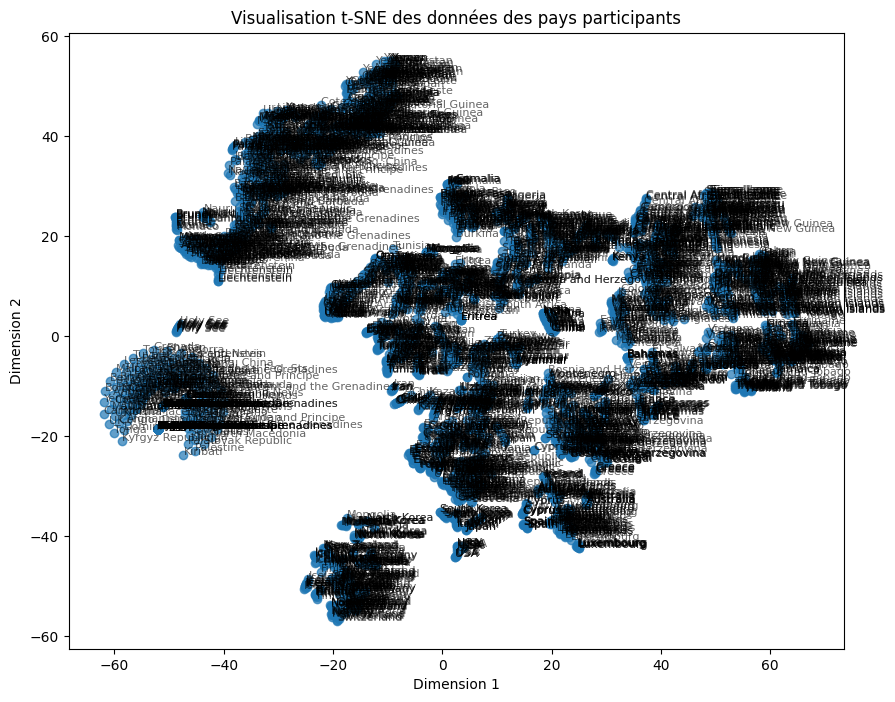

In [137]:
# Appliquer t-SNE avec une perplexité ajustée
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualisation
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7, cmap='viridis')
for i, country_name in enumerate(y):
    plt.text(X_tsne[i, 0], X_tsne[i, 1], country_name, fontsize=8, alpha=0.6)

plt.title("Visualisation t-SNE des données des pays participants")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [168]:
import plotly.express as px
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne_2d = tsne.fit_transform(X)

# Ajouter les composantes t-SNE et les noms des pays au DataFrame
final_df["TSNE1"] = X_tsne_2d[:, 0]
final_df["TSNE2"] = X_tsne_2d[:, 1]

# Visualisation interactive en 2D avec Plotly
fig = px.scatter(
    final_df,
    x="TSNE1",
    y="TSNE2",
    color="year",  # Coloration par année
    hover_name="country",  # Affiche le nom du pays au survol
    title="Visualisation t-SNE 2D des pays participants aux Jeux Olympiques",
    labels={"TSNE1": "Composante t-SNE 1", "TSNE2": "Composante t-SNE 2"},
    color_continuous_scale="viridis",  # Palette de couleurs
    opacity=0.7  # Transparence des points
)

# Afficher les noms des pays directement sur les points
fig.update_traces(textposition='top center', marker=dict(size=8))

# Affichage interactif
fig.show()


# PCA 

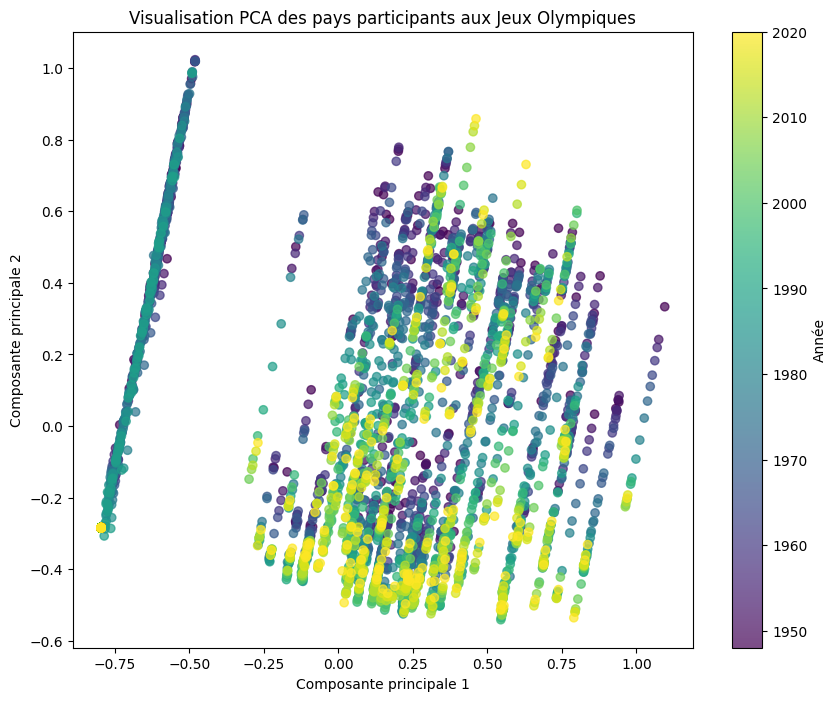

In [150]:
from sklearn.decomposition import PCA

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualisation
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_df["year"], cmap='viridis', alpha=0.7)
plt.title("Visualisation PCA des pays participants aux Jeux Olympiques")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(label="Année")
plt.show()

In [169]:
import plotly.express as px
from sklearn.decomposition import PCA

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X)

# Ajouter les composantes PCA au DataFrame
final_df["PCA1"] = X_pca_2d[:, 0]
final_df["PCA2"] = X_pca_2d[:, 1]

# Visualisation interactive en 2D avec Plotly
fig = px.scatter(
    final_df,
    x="PCA1",
    y="PCA2",
    color="year",  # Coloration par année
    hover_name="country",  # Affiche le nom du pays en survol
    title="Visualisation PCA 2D des pays participants aux Jeux Olympiques",
    labels={"PCA1": "Composante principale 1", "PCA2": "Composante principale 2"},
    color_continuous_scale="viridis",  # Palette de couleurs viridis
    opacity=0.7  # Transparence des points
)

# Affichage interactif
fig.show()


In [153]:
import plotly.express as px

# Appliquer PCA pour réduire à 3 dimensions
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X)

# Ajouter les composantes principales au DataFrame
final_df["PCA1"] = X_pca_3d[:, 0]
final_df["PCA2"] = X_pca_3d[:, 1]
final_df["PCA3"] = X_pca_3d[:, 2]

# Visualisation interactive en 3D avec Plotly
fig = px.scatter_3d(
    final_df,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    color="year",  # Coloration par année
    hover_name="country",  # Nom des pays affiché en survolant
    title="Visualisation PCA 3D des pays participants aux Jeux Olympiques",
    labels={"PCA1": "Composante principale 1", "PCA2": "Composante principale 2", "PCA3": "Composante principale 3"},
)

# Affichage
fig.show()


# UMAP

In [176]:
import umap.umap_ as umap  # Importer UMAP
import plotly.express as px

# Appliquer UMAP pour réduire à 2 dimensions
umap_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.3) # n_neighbors=15, min_dist=0.1
X_umap_2d = umap_2d.fit_transform(X)

# Ajouter les composantes UMAP au DataFrame
final_df["UMAP1"] = X_umap_2d[:, 0]
final_df["UMAP2"] = X_umap_2d[:, 1]

# Visualisation interactive en 2D avec Plotly
fig = px.scatter(
    final_df,
    x="UMAP1",
    y="UMAP2",
    color="year",  # Coloration par année
    hover_name="country",  # Nom des pays affiché en survolant
    title="Visualisation UMAP 2D des pays participants aux Jeux Olympiques",
    labels={"UMAP1": "Composante 1", "UMAP2": "Composante 2"},
)

# Affichage
fig.show()


In [158]:
# Appliquer UMAP pour réduire à 3 dimensions
umap_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1)
X_umap_3d = umap_3d.fit_transform(X)

# Ajouter les composantes UMAP au DataFrame
final_df["UMAP1"] = X_umap_3d[:, 0]
final_df["UMAP2"] = X_umap_3d[:, 1]
final_df["UMAP3"] = X_umap_3d[:, 2]

# Visualisation interactive en 3D avec Plotly
fig = px.scatter_3d(
    final_df,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="year",  # Coloration par année
    hover_name="country",  # Nom des pays affiché en survolant
    title="Visualisation UMAP 3D des pays participants aux Jeux Olympiques",
    labels={"UMAP1": "Composante 1", "UMAP2": "Composante 2", "UMAP3": "Composante 3"},
)

# Affichage
fig.show()